In [3]:
import argparse
import math
import os
import random

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import config as config
from sp_eyegan.preprocessing import data_loader as data_loader
from sp_eyegan.preprocessing import event_detection as event_detection
from sp_eyegan.preprocessing import smoothing as smoothing
from sp_eyegan.model import eventGAN as eventGAN

In [31]:
def get_scanpath_of_single_file(fixation_list):
    scanpath = []
    for i in range(len(fixation_list)):
        frame_no = fixation_list[i][0][6]
        scanpath.append([int(frame_no), fixation_list[i][5][0], fixation_list[i][5][1]])

    return np.array(scanpath)


def dva_to_vel(vector):
    vel = np.array(vector[1:]) - np.array(vector[0:-1])
    vel = np.array([0] + list(vel))
    return vel


def total_velocity_magnitude(vel_x, vel_y):
    vel_x_squared = vel_x ** 2
    vel_y_squared = vel_y ** 2
    magnitude_squared = vel_x_squared + vel_y_squared
    magnitude = np.sqrt(magnitude_squared)
    return magnitude

def ScreenCoord2AngularCoord(ScreenCoord):
    # Inverse transformation of screen coords (0-1) to angular coords (degrees).

    # Parameters of the Hmd (HTC Vive).
    # Vertical FOV.
    VerticalFov = math.pi * 110 / 180
    # Size of a half screen.
    ScreenWidth = 1080
    ScreenHeight = 1200
    # The pixel distance between the eye and the screen center.
    ScreenDist = 0.5 * ScreenHeight / math.tan(VerticalFov / 2)

    AngularCoord = np.zeros(2)

    # The X coord.
    AngularCoord[0] = (math.atan((ScreenCoord[0] - 0.5) * ScreenWidth / ScreenDist) * 180) / math.pi
    # The Y coord.
    AngularCoord[1] = (math.atan((ScreenCoord[1] - 0.5) * ScreenHeight / ScreenDist) * 180) / math.pi

    return AngularCoord

def resample_array(input_array, desired_length):
    current_length = len(input_array)
    
    if desired_length > current_length:
        # Upsample using linear interpolation
        indices = np.linspace(0, current_length - 1, num=desired_length)
        output_array = np.interp(indices, np.arange(current_length), input_array)
    elif desired_length < current_length:
        # Downsample by taking the average
        chunk_size = current_length // desired_length
        remaining = current_length % desired_length
        
        chunks = [input_array[i:i + chunk_size] for i in range(0, current_length - remaining, chunk_size)]
        if remaining:
            chunks.append(input_array[-remaining:])
        
        output_array = [np.mean(chunk) for chunk in chunks]
    else:
        # No change needed
        output_array = input_array.copy()
        
    return np.asarray(output_array)

In [33]:
# gloabal params
sampling_rate = 100

# params
smoothing_window_length = 0.007
disable = False
min_fixation_length = 10
max_fixation_dispersion = 2.7
max_vel = 500

target_sampling_rate = 100
sac_window_size = 10
fix_window_size = 10

task_ids = []
task = '1'
if task == 'all':
    task_ids = [1, 2, 3, 4]
else:
    task_ids.append(int(task))

video_no = '1'
video_ids = []
if video_no == 'all':
    video_ids = [i+1 for i in range(15)]
else:
    video_ids.append(int(video_no))

user_id = 1

In [34]:
gaze_data_list, gaze_feature_dict, gaze_label_matrix, gaze_label_dict = data_loader.load_ehtask_data(
        ehtask_dir='../data/EHTaskDataset/',
        target_sampling_rate=target_sampling_rate,
        sampling_rate=sampling_rate,
        task_ids=task_ids,
        video_ids=video_ids,
        user_id=user_id
    )

event_df_list = []
list_dicts_list = []
for i in tqdm(np.arange(len(gaze_data_list)), disable=False):
    x_dva = gaze_data_list[i][:, gaze_feature_dict['x_dva_left']]
    y_dva = gaze_data_list[i][:, gaze_feature_dict['y_dva_left']]
    x_pixel = gaze_data_list[i][:, gaze_feature_dict['x_left_px']]
    y_pixel = gaze_data_list[i][:, gaze_feature_dict['y_left_px']]
    corrupt = np.zeros([len(x_dva), ])
    corrupt_ids = np.where(np.logical_or(np.isnan(x_pixel),
                                         np.isnan(y_pixel)))[0]
    corrupt[corrupt_ids] = 1

    # apply smoothing like in https://digital.library.txstate.edu/handle/10877/6874
    smooth_vals = smoothing.smooth_data(x_dva, y_dva,
                                        n=2, smoothing_window_length=smoothing_window_length,
                                        sampling_rate=target_sampling_rate)

    # TODO smoothing check
    # x_smo = smooth_vals['x_smo']
    # y_smo = smooth_vals['y_smo']
    x_smo = x_dva
    y_smo = y_dva
    vel_x = smooth_vals['vel_x']
    vel_y = smooth_vals['vel_y']
    vel = smooth_vals['vel']
    acc_x = smooth_vals['acc_x']
    acc_y = smooth_vals['acc_y']
    acc = smooth_vals['acc']

    corrupt_vels = []
    corrupt_vels += list(np.where(vel_x > max_vel)[0])
    corrupt_vels += list(np.where(vel_x < -max_vel)[0])
    corrupt_vels += list(np.where(vel_y > max_vel)[0])
    corrupt_vels += list(np.where(vel_y < -max_vel)[0])

    corrupt[corrupt_vels] = 1

    # dispersion
    list_dicts, event_df = event_detection.get_sacc_fix_lists_dispersion(
        x_smo, y_smo,
        corrupt=corrupt,
        sampling_rate=target_sampling_rate,
        min_duration=min_fixation_length,
        velocity_threshold=20,
        flag_skipNaNs=False,
        verbose=0,
        max_fixation_dispersion=max_fixation_dispersion,
    )

    event_df_list.append(event_df)
    list_dicts_list.append(list_dicts)

print('number of lists: ' + str(len(event_df_list)))
#####################################################

fixation_list = []
list_dicts = list_dicts_list[i]
event_df = event_df_list[i]
fixations = list_dicts['fixations']
x_dva = gaze_data_list[i][:, gaze_feature_dict['x_dva_left']]
y_dva = gaze_data_list[i][:, gaze_feature_dict['y_dva_left']]
x_pixel = gaze_data_list[i][:, gaze_feature_dict['x_left_px']]
y_pixel = gaze_data_list[i][:, gaze_feature_dict['y_left_px']]

# apply smoothing like in https://digital.library.txstate.edu/handle/10877/6874
smooth_vals = smoothing.smooth_data(x_dva, y_dva,
                                    n=2, smoothing_window_length=smoothing_window_length,
                                    sampling_rate=target_sampling_rate)

# TODO smoothing fix
# x_smo = smooth_vals['x_smo']
# y_smo = smooth_vals['y_smo']
x_smo = x_dva
y_smo = y_dva
vel_x = smooth_vals['vel_x']
vel_y = smooth_vals['vel_y']
vel = smooth_vals['vel']
acc_x = smooth_vals['acc_x']
acc_y = smooth_vals['acc_y']
acc = smooth_vals['acc']

for f_i in range(len(fixations)):
    fixation_list.append(np.concatenate([
        np.expand_dims(x_smo[fixations[f_i]], axis=1),
        np.expand_dims(y_smo[fixations[f_i]], axis=1),
        np.expand_dims(x_pixel[fixations[f_i]], axis=1),
        np.expand_dims(y_pixel[fixations[f_i]], axis=1),
        np.expand_dims(vel_x[fixations[f_i]], axis=1) / target_sampling_rate,
        np.expand_dims(vel_y[fixations[f_i]], axis=1) / target_sampling_rate,
        np.expand_dims(fixations[f_i], axis=1),
    ], axis=1))

print('number of fixations: ' + str(len(fixation_list)))

filtered_fixation_list = []
mx_dispersion = 0.0
mn_len_x_dva = 10000
for f_i in tqdm(np.arange(len(fixation_list))):
    cur_x_dva = fixation_list[f_i][:, 0]
    cur_y_dva = fixation_list[f_i][:, 1]
    x_amp = np.abs(np.max(cur_x_dva) - np.min(cur_x_dva))
    y_amp = np.abs(np.max(cur_y_dva) - np.min(cur_y_dva))
    cur_dispersion = x_amp + y_amp
    mn_len_x_dva = min(mn_len_x_dva, len(cur_x_dva))
    mx_dispersion = max(mx_dispersion, cur_dispersion)
    if cur_dispersion >= max_fixation_dispersion:
        # print(f"cur_dispersion: {cur_dispersion}")
        continue
    if len(cur_x_dva) <= fix_window_size:
        # print(f"len(cur_x_dva): {len(cur_x_dva)}")
        continue
    filtered_fixation_list.append(fixation_list[f_i])
print('number of fixations after filtering: ' + str(len(filtered_fixation_list)))
print(f"mx_dispersion: {mx_dispersion}")
print(f"mn_len_x_dva: {mn_len_x_dva}")

print('number of fixations: ' + str(len(filtered_fixation_list)))
# store fixations and saccades
column_dict = {'x_dva': 0,
               'y_dva': 1,
               'x_px': 2,
               'y_px': 3,
               'x_dva_vel': 4,
               'y_dva_vel': 5,
               'frame': 6
               }

# joblib.dump(column_dict, 'data/column_dict.joblib', compress=3, protocol=2)

fix_lens = [filtered_fixation_list[a].shape[0] for a in range(len(filtered_fixation_list))]
print('fix_lens: ' + str(np.max(fix_lens)))

max_fix_len = fix_window_size
fixation_matrix = np.ones([len(filtered_fixation_list), max_fix_len, len(column_dict)]) * -1

for i in tqdm(np.arange(len(filtered_fixation_list))):
    cur_fix_len = np.min([max_fix_len, filtered_fixation_list[i].shape[0]])
    fixation_matrix[i, 0:cur_fix_len, :] = filtered_fixation_list[i][0:cur_fix_len, :]


print('fixation_matrix.shape: ', fixation_matrix.shape)

100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


number of lists: 1
number of fixations: 504


100%|██████████| 504/504 [00:00<?, ?it/s]


number of fixations after filtering: 419
mx_dispersion: 2.7
mn_len_x_dva: 1
number of fixations: 419
fix_lens: 234


100%|██████████| 419/419 [00:00<?, ?it/s]

fixation_matrix.shape:  (419, 10, 7)


In [35]:
scanpath = get_scanpath_of_single_file(fixation_matrix)
print('scanpath.shape: ', scanpath.shape)
# np.save('data/scanpath/single_file/scanpath_ehtask_user_' + str(user_id) + '_video_' + video_no + '_task_' + task, scanpath)

# params for generator
window_size = 10
random_size = 32
channels = 2
mean_sacc_len = 20
std_sacc_len = 10

mean_fix_len = 25
std_fix_len = 15

gen_kernel_sizes_fixation = [fix_window_size, 8, 4, 2]
gen_kernel_sizes_saccade = [sac_window_size, 8, 4, 2]
gen_filter_sizes = [16, 8, 4, 2]
channels = 2
relu_in_last = False
batch_size = 256

dis_kernel_sizes = [8, 16, 32]
dis_fiter_sizes = [32, 64, 128]
dis_dropout = 0.3

fixation_path = '../event_model/fixation_model_ehtask_giw_video_' + video_no + '_task_' + task
saccade_path = '../event_model/saccade_model_ehtask_giw_video_' + video_no + '_task_' + task

gan_config = {'window_size': window_size,
              'random_size': random_size,
              'channels': channels,
              'mean_sacc_len': mean_sacc_len,
              'std_sacc_len': std_sacc_len,
              'mean_fix_len': mean_fix_len,
              'std_fix_len': std_fix_len,
              'fixation_path': fixation_path,
              'saccade_path': saccade_path,
              }
model_config_fixation = {'gen_kernel_sizes': gen_kernel_sizes_fixation,
                         'gen_filter_sizes': gen_filter_sizes,
                         'dis_kernel_sizes': dis_kernel_sizes,
                         'dis_fiter_sizes': dis_fiter_sizes,
                         'dis_dropout': dis_dropout,
                         'window_size': fix_window_size,
                         'channels': channels,
                         'batch_size': batch_size,
                         'random_size': random_size,
                         'relu_in_last': relu_in_last,
                         }

model_config_saccade = {'gen_kernel_sizes': gen_kernel_sizes_saccade,
                        'gen_filter_sizes': gen_filter_sizes,
                        'dis_kernel_sizes': dis_kernel_sizes,
                        'dis_fiter_sizes': dis_fiter_sizes,
                        'dis_dropout': dis_dropout,
                        'window_size': sac_window_size,
                        'channels': channels,
                        'batch_size': batch_size,
                        'random_size': random_size,
                        'relu_in_last': relu_in_last,
                        }

data_generator = eventGAN.dataGenerator(gan_config,
                                        model_config_fixation,
                                        model_config_saccade,
                                        )
x_dva = scanpath[:, 1]
y_dva = scanpath[:, 2]

x_locations, y_locations, fix_x_loc, fix_y_loc, sac_x_loc, sac_y_loc = data_generator.sample_scanpath(
    x_fix_locations=x_dva,
    y_fix_locations=y_dva,
    num_sample_saccs=1000,
    dva_threshold=0.01,
    fixation_durations=None,
    saccade_durations=None,
)
print('x_locations.len: ', len(x_locations))

index1 = [i for i, x in enumerate(x_locations) if x == x_dva[100]]
print(index1)
index1 = [i for i, y in enumerate(y_locations) if y == y_dva[100]]
print(index1)
index2 = [i for i, x in enumerate(x_locations) if x == x_dva[101]]
print(index2)
index2 = [i for i, y in enumerate(y_locations) if y == y_dva[101]]
print(index2)

x_vals = x_locations[index1[0]:index2[0]+1]
y_vals = y_locations[index1[0]:index2[0]+1]

user_id = str(user_id)
if len(user_id) == 1:
    user_id = '0' + user_id
if len(video_no) == 1:
    video_str = '0' + video_no
else:
    video_str = video_no

scanpath.shape:  (419, 3)
x_locations.len:  20077
[4457]
[4457]
[4492]
[4492]


In [36]:
# frame_no = scanpath[:, 0]
# x_dva = scanpath[:, 1]
# y_dva = scanpath[:, 2]
# 
# # Create a scatter plot
# plt.figure(figsize=(12, 9))  # Set the figure size
# plt.scatter(x_dva, y_dva, c=frame_no, cmap='viridis', label=frame_no)
# 
# # Add labels and a colorbar
# plt.xlabel('x_dva')
# plt.ylabel('y_dva')
# plt.colorbar(label='frame_no')
# 
# # plt.legend()
# 
# plt.show()

[3336]
[3360]
x_vals len 36
giw_x_vals len 25
(36,)
(25,)
(25,)
(25,)
target_vel new shape:  (26,)


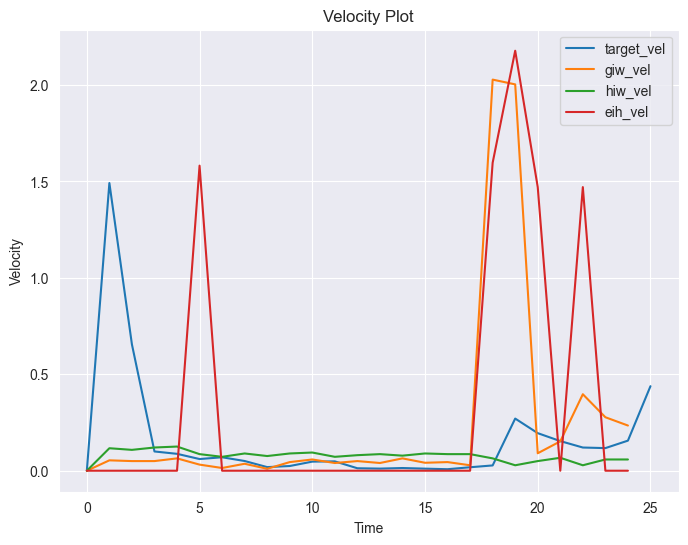

In [37]:
data_path = '../' + config.EHTASK_DIR + 'RawData/User_' + user_id + '_Video_' + video_str + '_Task_' + task + '.txt'

giw_x_vals = []
giw_y_vals = []
hiw_x_vals = []
hiw_y_vals = []
eih_x_vals = []
eih_y_vals = []

with open(data_path, 'r') as file:
    for line in file:
        values = line.split()

        giw_x_vals.append(float(values[6]))
        giw_y_vals.append(float(values[7]))

        hiw_x_vals.append(float(values[2]))
        hiw_y_vals.append(float(values[3]))

        eih_dvas = ScreenCoord2AngularCoord([float(values[4]), float(values[5])])

        eih_x_vals.append(eih_dvas[0])
        eih_y_vals.append(eih_dvas[1])

index1 = [i for i, x in enumerate(giw_x_vals) if x == x_dva[100]]
index2 = [i for i, x in enumerate(giw_x_vals) if x == x_dva[101]]

if len(index1) == 0:
    raise "index1 not found"
if len(index2) == 0:
    raise "index2 not found"

print(index1)
print(index2)

begin = index1[0]
end = index2[0]
for entry in index2:
    if entry > begin:
        end = entry
        break

giw_x_vals = giw_x_vals[begin:end + 1]
giw_y_vals = giw_y_vals[begin:end + 1]
hiw_x_vals = hiw_x_vals[begin:end + 1]
hiw_y_vals = hiw_y_vals[begin:end + 1]
eih_x_vals = eih_x_vals[begin:end + 1]
eih_y_vals = eih_y_vals[begin:end + 1]

print('x_vals len', len(x_vals))
print('giw_x_vals len', len(giw_x_vals))

x_vel = dva_to_vel(np.array(x_vals))
y_vel = dva_to_vel(np.array(y_vals))
giw_x_vel = dva_to_vel(np.array(giw_x_vals))
giw_y_vel = dva_to_vel(np.array(giw_y_vals))
hiw_x_vel = dva_to_vel(np.array(hiw_x_vals))
hiw_y_vel = dva_to_vel(np.array(hiw_y_vals))
eih_x_vel = dva_to_vel(np.array(eih_x_vals))
eih_y_vel = dva_to_vel(np.array(eih_y_vals))

target_vel = total_velocity_magnitude(x_vel, y_vel)
giw_vel = total_velocity_magnitude(giw_x_vel, giw_y_vel)
hiw_vel = total_velocity_magnitude(hiw_x_vel, hiw_y_vel)
eih_vel = total_velocity_magnitude(eih_x_vel, eih_y_vel)

print(target_vel.shape)
print(giw_vel.shape)
print(hiw_vel.shape)
print(eih_vel.shape)

target_vel = resample_array(target_vel, len(giw_vel))
print('target_vel new shape: ', target_vel.shape)
# time = np.linspace(0, 10, 100)  # Sample time values

# Create the plot
plt.figure(figsize=(8, 6))  # Set the figure size
plt.plot(range(len(target_vel)), target_vel, label='target_vel')
plt.plot(range(len(giw_vel)), giw_vel, label='giw_vel')
plt.plot(range(len(hiw_vel)), hiw_vel, label='hiw_vel')
plt.plot(range(len(eih_vel)), eih_vel, label='eih_vel')

# Set plot title and labels
plt.title('Velocity Plot')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()  # Show legend

# Save the plot as a PNG file
# plt.savefig('User_' + user_id + '_Video_' + video_str + '_Task_' + task + '.png')

# Show the plot (optional)
plt.show()